In [167]:
#Import everything 
import matplotlib.pyplot as plt
import numpy as np

import ffmpeg_wrap
import signal_tools as st
import fft



import os
import shutil
import sys
import ffmpeg
from PIL import Image
import imagehash
import cv2
import torch
from torchvision import models, transforms
from scipy.signal import correlate
from scipy.spatial.distance import *
from fastdtw import fastdtw
from dtaidistance import dtw
from scipy.signal import savgol_filter

from scipy.fftpack import rfft, irfft, fftfreq, fft, ifft
from scipy.signal import butter, lfilter
from scipy.interpolate import interp1d

%matplotlib inline

plt.rcParams["figure.figsize"] = (7,3)
plt.rcParams["figure.dpi"] = 150

In [168]:
#funtions to generate 2D video signal
def hamming_2d(shape):
    #This function make a 2d hamming window (fading circle)
    #Print Image of blob to see how it looks
    i,j = shape
    a = np.r_[[np.hamming(i)]*j].T
    b = np.c_[[np.hamming(j)]*i]
    return a*b


def blob_generator(shape):
    #This function generates a mask over the video.
    #The mask is a grid of four fading circles.
    #Print Image of blob to see how it looks
    i,j = shape
    ii = int(i//2); jj = int(j//2)
    ham2d = hamming_2d([ii,jj])
    arr = np.zeros([i,j])
    arr[:ii,:jj] = ham2d
    arr[:ii,-jj:] = -ham2d
    arr[-ii:,:jj] = -ham2d
    arr[-ii:,-jj:] = ham2d
    return arr

def butter_bandpass_response(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass_response(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



In [169]:
def normalize_signal(v):
    """
    Normalize a signal by removing the mean and dividing by the 90th percentile.

    Parameters:
        v (array-like): Input signal (list or NumPy array)

    Returns:
        np.ndarray: Normalized signal
    """
    v = np.array(v, dtype=np.float64)
    v -= np.mean(v)
    v /= np.percentile(v, 90)
    return v

def import_2D_video_signal(filename,shape):
    #Read video and output into 2D frames using ffmepg frame reader.
    frames = [] 
    with ffmpeg_wrap.FfmpegFrameReader(filename, shape) as r:
        f = r.get_next_frame()
        while f is not None:
            frames.append(f)
            f = r.get_next_frame()

    return frames

def convert_2_1D_signal_blob(frames,blob_mask):
    '''
    This function converts the 2D frames into a 1D video signal by applying the blob mask to the video
    by taking the areas of the blob pattern into consideration
    '''

    v = []
    for f in frames:
        v.append(np.sum(blob_mask.T*f[:,:,0]))

    return normalize_signal(v)

def convert_2_1D_signal_phash(frames):
    '''
    This function converts the 2D (image) frames into a 1D video signal by converting
    each frame into a 64-bit hash and then convert that into a int
    '''
    frame_signals= []
    for i in frames:
        img = Image.fromarray(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
        h = imagehash.phash(img)  # returns 64-bit hash
        frame_signals.append(int(str(h), 16))  # convert to integer
    return normalize_signal(np.array(frame_signals))

def convert_2_1D_signal_mpi(frames):
    '''
    This function converts the 2D (image) frames into a 1D video signal by converting
    each frame into a 64-bit hash and then convert that into a int
    '''
    frame_signals= []
    for i in frames:
        gray = (cv2.cvtColor(i, cv2.COLOR_BGR2GRAY))
        value = gray.mean()
        frame_signals.append(value)
    return normalize_signal(np.array(frame_signals))

def convert_2_1D_signal_cnn(frames):
    '''
    This function uses AI
    '''
    # 1. Load pretrained ResNet-18
    model = models.resnet18(pretrained=True)
    model.eval()  # Disable training mode

    # 2. Define transformation pipeline
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    ])

    scalars = []
    for i in frames:
        color_img = cv2.cvtColor(i, cv2.COLOR_YUV2RGB)
        img_pil = Image.fromarray(color_img)

        input_tensor = preprocess(img_pil).unsqueeze(0)  # Shape: [1, 3, 224, 224]

        with torch.no_grad():
            features = model(input_tensor)  # Shape: [1, 1000] (logits)

        # 5. Reduce to scalar (option A: vector norm)
        scalar_value = features.norm(p=2).item()
        scalars.append(scalar_value)

    return np.array(scalars)

def min_max_normalize(data, axis=None):
    """
    Normalize the data using min-max scaling to range [0, 1].

    Parameters:
    - data (array-like): Input data (can be list, NumPy array, etc.)
    - axis (int or None): Axis along which to normalize (None = flatten first)

    Returns:
    - np.ndarray: Normalized data with values between 0 and 1
    """
    data = np.asarray(data)
    min_val = np.min(data, axis=axis, keepdims=True)
    max_val = np.max(data, axis=axis, keepdims=True)

    # Avoid division by zero
    range_val = max_val - min_val
    range_val[range_val == 0] = 1

    return (data - min_val) / range_val

**Settings**

In the following block a few settings can be chosen for the import of the video etc...

In [170]:
#Resolution of 2D signal (This can be small, to import it)
width_video = 40
height_video = int(width_video/1.77777)

br_fr = 24
vhs_fr = 25

skip_start_br = (60+20)*br_fr
skip_end_br = (60+56)*br_fr
# skip_end_br = 0

skip_start_vhs =(60+20)*vhs_fr
skip_end_vhs = (60+9)*vhs_fr
# skip_end_vhs = 0

video_shape = (width_video,height_video)

In [171]:
#Convert videos to 1D signal
# br_frames = import_2D_video_signal('F:/heidi_files/development/br.mkv',video_shape)
# vhs_frames = import_2D_video_signal('F:/heidi_files/development/vhs.mp4',video_shape)

br_frames = import_2D_video_signal('F:/heidi_files/development/br_full.mkv',video_shape)
vhs_frames = import_2D_video_signal('F:/heidi_files/development/vhs_full.mp4',video_shape)

print("Number of Blu-ray Frames before cuts: ",len(br_frames))
print("Number of VHS Frames before cuts: ",len(vhs_frames))

#skip start and end
br_frames = br_frames[skip_start_br: len(br_frames) - skip_end_br - 1]
vhs_frames = vhs_frames[skip_start_vhs: len(vhs_frames) - skip_end_vhs - 1]

print("Number of Blu-ray Frames after cuts: ",len(br_frames))
print("Number of VHS Frames after cuts: ",len(vhs_frames))

37094
35763
32389
32037


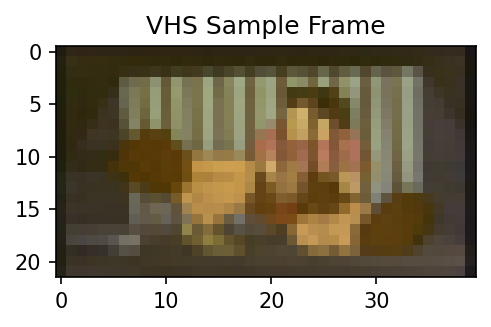

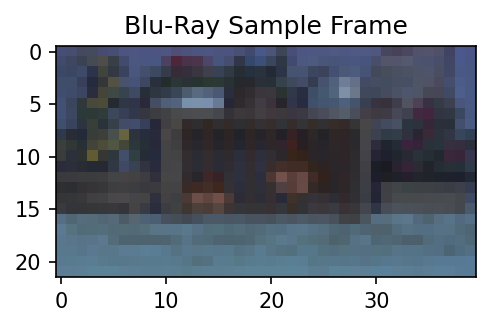

In [172]:
#Just a test to see if the video frames were correctly read
view_frame_num = 1000

plt.figure(figsize=(8,2))
plt.imshow(cv2.cvtColor(vhs_frames[view_frame_num], cv2.COLOR_YUV2RGB))
plt.title('VHS Sample Frame')
plt.show()  # Display the image

plt.figure(figsize=(8,2))
plt.imshow(cv2.cvtColor(br_frames[view_frame_num+90], cv2.COLOR_YUV2RGB))
plt.title('Blu-Ray Sample Frame')
plt.show()  # Display the image

Coverting video signal to one-dimentional array methods

In [ ]:
#Phash method
# br_sig = convert_2_1D_signal_phash(br_frames)
# vhs_sig = convert_2_1D_signal_phash(vhs_frames)

# plt.figure(figsize=(8,2))
# plt.plot(br_sig,color="b",label="Blu-Ray")
# plt.plot(vhs_sig,color="r",label="VHS")
# plt.legend(ncol=2)

#Comment: Nah

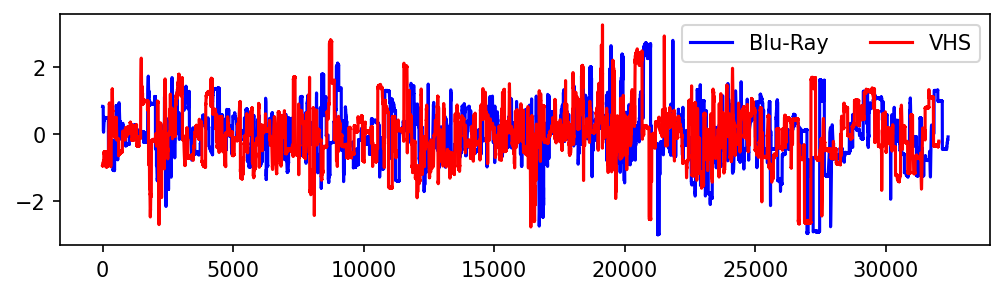

In [173]:
#Simon Blob
br_sig = convert_2_1D_signal_blob(br_frames,blob_generator(video_shape))
vhs_sig = convert_2_1D_signal_blob(vhs_frames,blob_generator(video_shape))

plt.figure(figsize=(8,2))
plt.plot(br_sig,color='b',label="Blu-Ray")
plt.plot(vhs_sig,color='r',label="VHS")
plt.legend(ncol=2)

#Comment: Looking good

In [ ]:
#MPI (mean point index)
# br_sig = convert_2_1D_signal_mpi(br_frames)
# vhs_sig = convert_2_1D_signal_mpi(vhs_frames)

# plt.figure(figsize=(8,2))
# plt.plot(br_sig,color='b',label="Blu-Ray")
# plt.plot(vhs_sig,color='r',label="VHS")
# plt.legend(ncol=2)

#Comment: Also a possibility

In [ ]:
#AI
# br_sig = convert_2_1D_signal_cnn(br_frames)
# vhs_sig = convert_2_1D_signal_cnn(vhs_frames)

# plt.figure(figsize=(8,2))
# plt.plot(br_sig,color='b',label="Blu-Ray")
# plt.plot(vhs_sig,color='r',label="VHS")
# plt.legend(ncol=2)

#Comment: Best but takes to long

Match the two signals - Mapping and correlations

Best shift: 327 frames


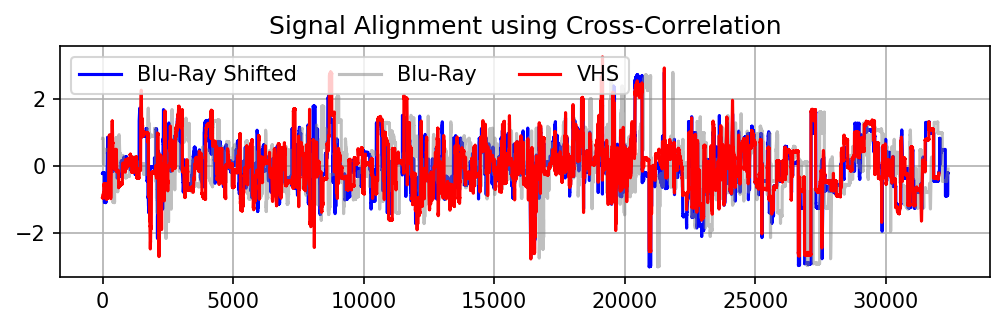

In [198]:
# Compute cross-correlation
corr = correlate(br_sig,vhs_sig, mode='full',)
lags = np.arange(-len(vhs_sig)+1, len(br_sig))

best_shift = lags[np.argmax(corr)]
print(f"Best shift: {best_shift} frames")

# Shift x accordingly (manual shifting)
x_shifted = np.roll(br_sig, -best_shift)

# Plotting
plt.figure(figsize=(8,2))
plt.plot(x_shifted,color='b',label="Blu-Ray Shifted")
plt.plot(br_sig,color='grey',label="Blu-Ray",alpha=0.5)
plt.plot(vhs_sig,color='r',label="VHS")
plt.legend(ncol=3)
plt.title('Signal Alignment using Cross-Correlation')
plt.grid(True)
random_point = 30000
# plt.xlim(random_point,random_point+2000)
plt.show()

In [ ]:
#Reduce number of points
def reduce_via_pooling(x, num_points, method='mean'):
    n = len(x)
    pool_size = n // num_points
    reduced = []

    for i in range(0, n, pool_size):
        chunk = x[i:i+pool_size]
        if method == 'mean':
            reduced.append(np.mean(chunk))
        elif method == 'max':
            reduced.append(np.max(chunk))
    return np.array(reduced)

x_reduced = reduce_via_pooling(np.abs(dx_dt), 200, method='max')
y_reduced = reduce_via_pooling(np.abs(dv_dt), 200, method='max')

plt.figure(figsize=(8,2))
plt.plot(dx_dt,color='g',label="Blu-Ray diff")
plt.plot(dv_dt,color='r',label="VHS diff")
plt.legend(ncol=3)
plt.title('Signal Alignment using Cross-Correlation')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,2))
plt.plot(x_reduced,color='g',label="Blu-Ray diff")
plt.plot(y_reduced,color='r',label="VHS diff")
plt.legend(ncol=3)
plt.title('Signal Alignment using Cross-Correlation')
plt.grid(True)
plt.show()


**DTW**

In [ ]:
#filtering
fs = 25
br_sig_smooth = savgol_filter(x_reduced, window_length=151, polyorder=3)
vhs_sig_smooth = savgol_filter(dv_dt, window_length=151, polyorder=3)

br_sig_smooth = dx_dt
vhs_sig_smooth = dv_dt

# br_sig_smooth = (butter_bandpass_filter(br_sig_smooth, 3, 10, 25, order=2))*1.0
# vhs_sig_smooth = (butter_bandpass_filter(br_sig_smooth, 3, 10, 25, order=2))*1.0

threshold = 0.005
# br_sig_smooth = np.where(np.abs(br_sig_smooth) < threshold, 0, br_sig_smooth)
# vhs_sig_smooth = np.where(np.abs(vhs_sig_smooth) < threshold, 0, vhs_sig_smooth)

plt.figure(figsize=(8,2))
plt.plot(br_sig_smooth,color='b',label="Blu-Ray")
plt.plot(vhs_sig_smooth,color='r',label="VHS")
plt.legend(ncol=3)
plt.title('Signals Filtered')
plt.grid(True)
# plt.xlim(3200,3600)
plt.ylim(-0.02,0.02)
plt.show()

In [ ]:
distance, paths = dtw.warping_paths(br_sig_smooth, vhs_sig_smooth, use_c=False)
best_path = dtw.best_path(paths)
similarity_score = distance / len(best_path)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(br_sig_smooth, label='BR', color='blue', marker='o')
plt.plot(vhs_sig_smooth, label='VHS', color='r', marker='x', linestyle='--')
for a, b in best_path:
    plt.plot([a, b], [br_sig_smooth[a], vhs_sig_smooth[b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
plt.title('Point-to-Point Comparison After DTW Alignment')
plt.xlim(1000,1200)
plt.ylim(-0.01,0.01)
plt.legend()

speel

In [ ]:
# br_sig = min_max_normalize(convert_2_1D_signal_mpi(br_frames),axis=0)
# vhs_sig = min_max_normalize(convert_2_1D_signal_mpi(vhs_frames),axis=0)



distance, path = fastdtw(vhs_sig_smooth, br_sig_smooth, dist=lambda a, b: abs(a - b)) #Manhattand Distance
# distance, path = fastdtw(vhs_sig, br_sig, dist=lambda a, b: (a - b)**2) #Squared Euclidian distance


mapping = defaultdict(list)
for i, j in path:
    mapping[i].append(br_sig_smooth[j])

# Create warped y by averaging y values mapped to each x index
br_warped = np.array([np.mean(mapping[i]) if i in mapping else np.nan for i in range(len(vhs_sig_smooth))])

# Plot signals
plt.figure(figsize=(10,4))
plt.plot(br_warped,color='g',label="Blu-Ray Warped")
plt.plot(br_sig_smooth,color='b',label="Blu-Ray")
plt.plot(vhs_sig_smooth,color='r',label="VHS")
plt.legend(ncol=3)
plt.title('Signal Alignment using Cross-Correlation')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from collections import defaultdict

# Create example signals
x = np.sin(np.linspace(0, 3*np.pi, 100))
y = 0.7 * np.sin(np.linspace(0, 3*np.pi, 120))  # Different length and amplitude

# Normalize signals to focus on shape
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

x_norm = normalize(x)
y_norm = normalize(y)

# Distance function for scalars
def abs_distance(a, b):
    return abs(a - b)

# Compute DTW distance and path
distance, path = fastdtw(x_norm, y_norm, dist=abs_distance)
print(f"Global DTW distance: {distance}")
print(f"Warping path length: {len(path)}")

# Map y indices to corresponding x indices along warping path
mapping = defaultdict(list)
for i, j in path:
    mapping[i].append(y_norm[j])

# Create warped y by averaging y values mapped to each x index
y_warped = np.array([np.mean(mapping[i]) if i in mapping else np.nan for i in range(len(x_norm))])

# Plot signals
plt.figure(figsize=(8,2))
plt.plot(y_warped,color='g',label="Blu-Ray Warped")
plt.plot(br_sig_n,color='b',label="Blu-Ray")
plt.plot(vhs_sig_n,color='r',label="VHS")
plt.legend(ncol=3)
plt.title('Signal Alignment using Cross-Correlation')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

# Generate two sample time series
x = np.linspace(0, 6.28, 100)
series_a = np.sin(x)
series_b = np.sin(x + 0.5) + 0.1*np.random.randn(100)  # slightly shifted and noisy

# Compute DTW
distance, path = fastdtw(series_a, series_b, dist=euclidean)

# Plotting
plt.figure(figsize=(12, 6))

# Time series
plt.subplot(1, 2, 1)
plt.plot(series_a, label='Series A')
plt.plot(series_b, label='Series B')
plt.title('Time Series')
plt.legend()

# Warping path
plt.subplot(1, 2, 2)
for (i, j) in path:
    plt.plot([i, j], [series_a[i], series_b[j]], color='gray', linewidth=0.5)
plt.plot(series_a, label='Series A')
plt.plot(series_b, label='Series B')
plt.title('Warping Path Visualization')
plt.legend()

plt.tight_layout()
plt.show()

Simple slice correlation

In [191]:
def simple_slice_maker(xlen, wsize, overlap_frac=0.1):
    """
    Simplified version of slice_maker.

    Parameters
    ----------
    xlen : int
        Length of signal to slice.
    wsize : int
        Window size for each slice.
    overlap_frac : float
        Fraction of window to overlap (e.g. 0.1 = 10% overlap).

    Yields
    ------
    (i, j): tuple
        Start and end indices of window.
    dampwin: np.ndarray
        Cosine window taper of length (j - i).
    """
    overlap = int(wsize * overlap_frac)
    step = wsize - overlap
    lovlap = overlap // 2
    rovlap = overlap - lovlap

    # Cosine taper
    curve = np.cos(np.linspace(np.pi, 0, overlap)) * 0.5 + 0.5

    for start in range(0, xlen, step):
        i = max(0, start - lovlap)
        j = min(xlen, start + wsize + rovlap)
        winlen = j - i

        dampwin = np.ones(winlen)
        if i > 0:
            dampwin[:overlap] *= curve
        if j < xlen:
            dampwin[-overlap:] *= curve[::-1]

        yield (i, j), dampwin

In [193]:
def fft_phase_offset(sig1, sig2, upsample=1):
    """
    Estimate the time delay (offset) between two signals using FFT phase correlation.

    Parameters
    ----------
    sig1 : np.ndarray
        Reference signal (1D).
    sig2 : np.ndarray
        Signal to align (1D), same length as sig1.
    upsample : int, optional
        If >1, upsamples the cross-correlation for sub-sample accuracy.

    Returns
    -------
    offset : float
        Estimated delay: sig2 should be shifted by this amount to align with sig1.
    correlation : float
        Maximum correlation value (normalized).
    """
    N = len(sig1)
    if len(sig2) != N:
        raise ValueError("Signals must be the same length")

    # Remove mean
    sig1 = sig1 - np.mean(sig1)
    sig2 = sig2 - np.mean(sig2)

    # FFTs
    f1 = np.fft.fft(sig1)
    f2 = np.fft.fft(sig2)

    # Cross-power spectrum
    R = f1 * np.conj(f2)
    R /= np.abs(R) + 1e-8  # Normalize to avoid magnitude bias

    # Inverse FFT to get cross-correlation
    cc = np.fft.ifft(R).real
    cc = np.fft.fftshift(cc)

    # Upsample (optional, for sub-sample accuracy)
    if upsample > 1:
        cc = np.interp(
            np.linspace(0, N-1, N * upsample),
            np.arange(N),
            np.fft.fftshift(cc)
        )
        max_idx = np.argmax(cc)
        offset = max_idx / upsample - N // 2
    else:
        max_idx = np.argmax(cc)
        offset = max_idx - N // 2

    # Normalize correlation (optional)
    correlation = cc[max_idx] / (np.linalg.norm(sig1) * np.linalg.norm(sig2) + 1e-8)

    return offset, correlation

In [196]:
def compute_delay_map_simple(sig1, sig2, nwindows=10, upsample=10):
    """
    Estimate a delay map between two signals using simple overlapping slices and phase correlation.


    Signal 1 = Afrikaans
    Signal 2 = Other Language

    nwindows : int, optional | This is the number of equally spaced windows to use.
    upsample : int, optional | Upsamples the signal be better granularity.

    """
    N = min(len(sig1), len(sig2))
    sig1 = sig1[:N]
    sig2 = sig2[:N]

    delay_map = np.zeros(N)
    weight = np.zeros(N)

    for i0, i1 in slice_maker_simple(N, nwindows=nwindows):
        slice1 = sig1[i0:i1]
        slice2 = sig2[i0:i1]

        delay, _ = fft_phase_offset(slice1, slice2, upsample=upsample)  # FFT based phase delay
        # delay = normal_correlation(slice1, slice2)                      # Normal Correlation

        # Apply result to region
        delay_map[i0:i1] += delay
        weight[i0:i1] += 1

    # Normalize by count
    weight[weight == 0] = 1e-8 # make sure you don't device by 0
    return delay_map / weight